In [57]:
from keras.models import load_model
import os
import librosa, librosa.display
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
import IPython.display as ipd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import shutil
from pydub import AudioSegment
import time

In [58]:
class_names = ['burping', 'discomfort', 'hungry', 'poop', 'tired']

In [59]:
model = load_model('./h5_model/mel_model.h5')

In [60]:
def load_audio(file_path):
    waveform, sample_rate = librosa.load(file_path,sr= 16000)
    db = 25
    waveform_trim ,dur= librosa.effects.trim(waveform, top_db=db )
    return waveform_trim, sample_rate

def load_audio_files(path: str, label:str):

    dataset = []
    walker = sorted(str(p) for p in Path(path).glob(f'*.wav'))
    for i, file_path in enumerate(walker):
        path, filename = os.path.split(file_path)
        # Load audio
        waveform, sample_rate = load_audio(file_path)
        audio_segment = AudioSegment.from_file(file_path)
        dataset.append([waveform, sample_rate,audio_segment])

    return dataset


In [61]:
def mel_spectrogram(waveform,sample,n_fft=2560,hop_length=32):
    #fast_fourier_transf = np.fft.fft(waveform)
   
    audio_stft = librosa.feature.melspectrogram(y=waveform,n_fft=n_fft,hop_length=hop_length,fmin = 20,fmax = sample//2)
    log_spectro = librosa.power_to_db(audio_stft)
    librosa.display.specshow(log_spectro, sr=sample, x_axis='time', y_axis='mel',cmap = 'magma')
    
    
    return log_spectro

In [62]:
def mel_freq(waveform,sample):
    mfccs = librosa.feature.mfcc(waveform, sr=sample,dct_type = 2,n_mfcc=100)
    # data = librosa.power_to_db(mfccs)
    # Displaying  the MFCCs:
    librosa.display.specshow(mfccs, sr=sample, x_axis='mel',cmap = 'magma')
    return mfccs

In [63]:
def create_images(data,typeimg):
    # make directory

    test_directory = f'./testImgArea/y_label/'

    os.makedirs(test_directory, mode=0o777, exist_ok=True)
    sample_rate = data[1]
    waveform = data[0]
    if typeimg == 'mel_spectrogram':
        spectrogram = mel_spectrogram(waveform,sample_rate)
    elif typeimg == 'mel_freq':
        spectrogram = mel_freq(waveform,sample_rate)
    librosa.display.specshow(spectrogram,sr=sample_rate, x_axis='time')
    plt.axis('off')
    plt.savefig(f'./testImgArea/y_label/test_{typeimg}.jpg', bbox_inches="tight", pad_inches = 0)
    plt.clf()

In [64]:
def getTestData():
    
    data_ds = tf.keras.preprocessing.image_dataset_from_directory('./testImgArea/', labels='inferred', label_mode='int', image_size=(432, 288), seed=321,validation_split=None, subset=None)
    fe=[]
    lab=[]
    for images, labels in data_ds.unbatch().take(-1):
        fe.append(images.numpy())
        lab.append(labels.numpy())

    return np.array(fe),np.array(lab)

In [72]:
predictset= []
labelset = []

In [73]:
split_class_model = load_model('./h5_model/split_class_model.h5')
burpAndPoop_model = load_model('./h5_model/burpAndPoop.h5')
HungryTiredAndDiscomfort_model = load_model('./h5_model/HungryTiredAndDiscomfort.h5')

In [81]:
def predict_infant(class_test_data,y_label):
    for testobj in class_test_data:
        create_images(testobj,typeimg ='mel_spectrogram')
        x,y = getTestData()
        # time.sleep(10)
        os.remove('./testImgArea/y_label/test_mel_spectrogram.jpg')
        pred = model.predict(x)
        y_pred_class = np.argmax(pred, axis=1)
        predictset.append(y_pred_class)
        labelset.append(y_label)
        plt.clf()
        
# def predict_infant(class_test_data,y_label):
#     for testobj in class_test_data:
#         create_images(testobj,typeimg ='mel_spectrogram')
        
#         x_mel,y = getTestData()
#         os.remove('./testImgArea/y_label/test_mel_spectrogram.jpg')
#         create_images(testobj,typeimg ='mel_freq')
#         x_mfcc,y = getTestData()
#         os.remove('./testImgArea/y_label/test_mel_freq.jpg')
#         pred = model.predict(x=[x_mel,x_mfcc])
#         y_pred_class = np.argmax(pred, axis=1)
#         predictset.append(y_pred_class)
#         labelset.append(y_label)
#         plt.clf()

# def predict_infant(class_test_data,y_label):
#     for testobj in class_test_data:
#         create_images(testobj,typeimg ='mel_freq')
#         x,y = getTestData()

#         os.remove('./testImgArea/y_label/test_mel_freq.jpg')
#         # x = np.array(x)

#         pred = split_class_model.predict(x)
#         y_pred_splittype = np.argmax(pred, axis=1)
#         create_images(testobj,typeimg ='mel_spectrogram')
#         x,y = getTestData()
#         # x = np.array(x)
#         time.sleep(10)
#         os.remove('./testImgArea/y_label/test_mel_spectrogram.jpg')
#         if y_pred_splittype == 1:
#             pred = burpAndPoop_model.predict(x)
#             y_pred_class = np.argmax(pred, axis=1)
#             y_pred_class = y_pred_class+3
#         else :
#             pred = HungryTiredAndDiscomfort_model.predict(x)
#             y_pred_class = np.argmax(pred, axis=1)
           
#             # y = y+2
#         predictset.append(y_pred_class)
#         labelset.append(y_label)
    

In [82]:
burping_test_data = load_audio_files('./data_eval/sound_data/Unseen_data/burpme/', 'burpme')
tired_test_data = load_audio_files('./data_eval/sound_data/Unseen_data/tired_owh/', 'tired')
hungry_test_data = load_audio_files('./data_eval/sound_data/Unseen_data/hungry_Nah/', 'hungry')
poop_test_data = load_audio_files('./data_eval/sound_data/Unseen_data/poop_eairh/', 'poop')
discomfort_test_data = load_audio_files('./data_eval/sound_data/Unseen_data/uncomfortable_heh/', 'discomfort')

In [83]:
# 3 model only
# class_names= ['discomfort', 'hungry', 'tired', 'burping', 'poop']
# predict_infant(discomfort_test_data,0)
# predict_infant(hungry_test_data,1)
# predict_infant(tired_test_data,2)
# predict_infant(burping_test_data,3)
# predict_infant(poop_test_data,4)

In [84]:
predict_infant(discomfort_test_data,1)
predict_infant(hungry_test_data,2)
predict_infant(tired_test_data,4)
predict_infant(burping_test_data,0)
predict_infant(poop_test_data,3)

Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

              precision    recall  f1-score   support

           0       0.33      0.20      0.25         5
           1       0.17      0.25      0.20        12
           2       0.00      0.00      0.00        12
           3       0.10      0.14      0.12         7
           4       0.21      0.23      0.22        13

    accuracy                           0.16        49
   macro avg       0.16      0.16      0.16        49
weighted avg       0.15      0.16      0.15        49



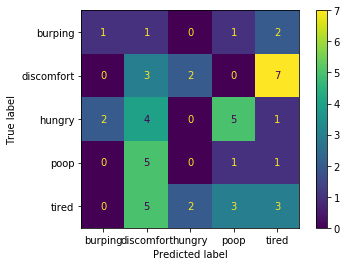

In [78]:

cm = confusion_matrix(labelset, predictset)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels = class_names)
disp.plot()
plt.show

from sklearn.metrics import classification_report
print(classification_report(labelset, predictset))